# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


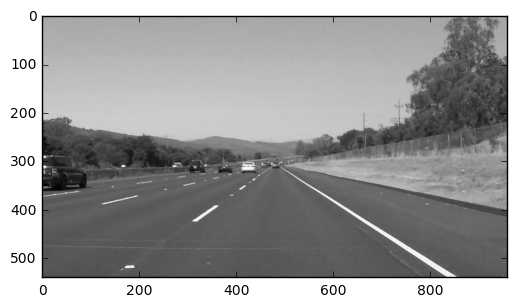

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, xIntersect=0, yIntersect=0, color=[255, 0, 0], thickness=2, extrapolateFlag=False, intelligentFlag=True, alpha=5, beta=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    drawNFlag = True
    drawPFlag = True
    slopes = []
    slopesN = []
    lanesN = []
    lanesP = []
    slopesP = []
    thr = 0.5
    halfSpace = img.shape[1]/2
    #print(halfSpace)
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = ((y2-y1)/(x2-x1))
            slopes.append(slope)
            
            
            # additional Restriction
            # | (np.sign(x1-halfSpace)>0 and np.sign(x2-halfSpace)>0) + (np.sign(slope) > 0)
            # | (np.sign(x1-halfSpace)<0 and np.sign(x2-halfSpace)<0) + (np.sign(slope) < 0)
            if extrapolateFlag == True:
                if not np.isinf(slope) and not np.isnan(slope) and abs(slope)>thr:
                    if (np.sign(slope) < 0) and (np.sign(x1-halfSpace)<0 and np.sign(x2-halfSpace)<0):
                        slopesN.append(slope)
                        lanesN.append(line)
                        #x = np.hstack([x,slope])
                    if (np.sign(slope) > 0) and (np.sign(x1-halfSpace)>0 and np.sign(x2-halfSpace)>0):
                        slopesP.append(slope)
                        lanesP.append(line)
            else:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)


    if extrapolateFlag == True:
        # We already filtered out redundant lines using our mask technique
        #filter out slopes        
        slopesN = np.array(slopesN)
        lanesN = np.array(lanesN)
        lanesP = np.array(lanesP)
        slopesP = np.array(slopesP)
        nSlope = np.mean(slopesN)
        indices = np.where((slopesN>nSlope) | (slopesN<2*nSlope))
        slopesN = np.delete(slopesN, indices, axis=0)
        lanesN = np.delete(lanesN, indices, axis=0)
        pSlope = np.mean(slopesP)
        indices = np.where((slopesP<pSlope) | (slopesP>2*pSlope))
        slopesP = np.delete(slopesP, indices, axis=0)
        lanesP = np.delete(lanesP, indices, axis=0)
        
        # something is wrong in detection
        if lanesP.size==0 | slopesP.size==0:
            drawPFlag = False
            yMaxP = yMaxN = img.shape[0]
        else:
            #yMaxP = np.max(lanesP[:,:,[1,2]])
            yMaxP = yMaxN = img.shape[0]

            
        if lanesN.size==0 | slopesN.size==0:
            drawNFlag = False
            yMaxP = yMaxN = img.shape[0]
        else:
            #yMaxN = np.max(lanesN[:,:,[1,2]])
            yMaxP = yMaxN = img.shape[0]
            

        
        # we already found x and y of intersect point using my intelligent mask detection algorithm
        bP = yIntersect - pSlope*xIntersect
        bN = yIntersect - nSlope*xIntersect

        #yMaxP = yMaxN = img.shape[0] # this will failed for the extra challenge
        
        xMinP = abs((yMaxP - bP)/pSlope)
        xMinN = abs((yMaxN - bN)/nSlope)
        
        #print(xIntersect, yIntersect, xMinN, xMinP, yMinN)
        if (not np.isnan(xMinN)) & (not np.isnan(xMinP)) & (not np.isnan(xIntersect)) & (not np.isnan(yIntersect)) : # check if something is wrong
            if drawNFlag & drawPFlag:
                cv2.line(img, (int(xIntersect-alpha), int(yIntersect+beta)), (int(xMinN), int(yMaxN)), color, 12)
            #if drawPFlag:
                cv2.line(img, (int(xIntersect+alpha), int(yIntersect+beta)), (int(xMinP), int(yMaxP)), color, 12)
            
                 
        

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, color=[255, 0, 0], thickness=2, intelligentFlag=True, extrapolateFlag=False,showMask=False,alpha=5,beta=10):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    successfulFlag = True
    xIntersect = yIntersect = 0 # intialize only for the case of intelligentFlag off
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros(img.shape, dtype=np.uint8)
    if (intelligentFlag==True):
        vertices, xIntersect, yIntersect = intelligentMaskDetection(lines,img.shape,alpha,beta)
        newImg = region_of_interest(img,vertices)
        lines = cv2.HoughLinesP(newImg, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
        if (showMask==True):
            cv2.fillPoly(line_img,vertices,255)
    if lines is None: # do it without intelligent mask detection :(
        successfulFlag = False
        return line_img, successfulFlag
        '''imshape = img.shape
        vertices = np.array([[(0,imshape[0]),(imshape[1]/2+3*imshape[0]/70, imshape[0]/3+imshape[0]/4), (imshape[1]/2+imshape[0]/70, imshape[0]/3+imshape[0]/4), (imshape[1],imshape[0])]], dtype=np.int32)
        masked = region_of_interest(img,vertices)
        lines = cv2.HoughLinesP(masked, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
        print(lines.shape)'''
    if (xIntersect == -1) | (yIntersect == -1 | np.isnan(xIntersect) | np.isnan(yIntersect)): #somthing is wrong
        #maskVertices = draw_lines(line_img, lines, 0, 0, color, thickness, False, False, 0, 0)
        # do nothing
        successfulFlag = False
    else:
        maskVertices = draw_lines(line_img, lines, xIntersect, yIntersect, color, thickness, extrapolateFlag, intelligentFlag, alpha, beta)
    return line_img, successfulFlag

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [4]:
# additional Functions
# yellow  ([196, 145, 10], [255, 245, 180])
# white ([200, 200, 200], [255, 255, 255])
def preProcess(img, boundaries):
    '''
    pre process the input can help us to make better result
    for example an Input image (RGB) filterd by color because we need only yellow and white colors
    '''
    result = np.zeros_like(img)  
    for (lower, upper) in boundaries:
        lower = np.array(lower, dtype = "uint8")
        upper = np.array(upper, dtype = "uint8")
        mask = cv2.inRange(img, lower, upper)
        output = cv2.bitwise_and(img, img, mask = mask)
        result = cv2.addWeighted(result, 1., output, 1., 0.)
    
    return result

def intelligentMaskDetection(lines, imshape, alpha=5, beta=10): # my special function to find mask in a more intelligent manner :D
    # find slope
    slopes = []
    longestLineX1 = 0
    longestLineX2 = 0
    longestLineY1 = 0
    longestLineY2 = 0
    longestLine1 = 0
    longestLine2 = 0
    longestNSlope = 0 # default Parameter
    longestPSlope = 0 # default Parameter
    thr = 0.5
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = ((y2-y1)/(x2-x1))
            slopes.append(slope)
            euclideanDist = np.sqrt((y2-y1)**2+(x2-x1)**2)
            if (abs(slope)>thr):
                if ((np.sign(slope) > 0) & (not np.isnan(slope)) & (not np.isinf(slope))):
                    if euclideanDist >= longestLine1: # calculate Euclidean Distance
                        longestLine1 = euclideanDist
                        longestLineX1 =x1
                        longestLineY1 =y1
                        longestPSlope = slope
                elif ((np.sign(slope) < 0) & (not np.isnan(slope)) & (not np.isinf(slope))): 
                    if euclideanDist >= longestLine2: # calculate Euclidean Distance
                        longestLine2 = euclideanDist
                        longestLineX2 =x2
                        longestLineY2 =y2
                        longestNSlope = slope

    # more clever way to do mask
    npArray = np.array(slopes)
    npArray[np.isnan(npArray)] = 0
    npArray[np.isinf(npArray)] = 0

    negativeSlope = longestNSlope
    positiveSlope = longestPSlope

    x1 = longestLineX1
    y1 = longestLineY1
    x2 = longestLineX2
    y2 = longestLineY2
    
    # using line y-y0 = m (x-x0) and a little bit of math we have:
    xIntersect = abs((positiveSlope * x1 - negativeSlope * x2 + y2 - y1)/(positiveSlope-negativeSlope))
    yIntersect = abs((positiveSlope*negativeSlope*(x1-x2)+positiveSlope*y2 - negativeSlope*y1)/(positiveSlope-negativeSlope))

    # alpha and beta are heuristic variable 
    
    maskVertices = np.array([[(0,imshape[0]),(xIntersect-alpha,yIntersect+beta),(xIntersect+alpha,yIntersect+beta),(imshape[1],imshape[0])]], dtype=np.int32)

    if np.isnan(xIntersect) |  np.isnan(yIntersect): # do it in manual way :(
        xIntersect = -1
        yIntersect = -1
        maskVertices = np.array([[(0,imshape[0]),(imshape[1]/2+3*imshape[0]/70, imshape[0]/3+imshape[0]/4), (imshape[1]/2+imshape[0]/70, imshape[0]/3+imshape[0]/4), (imshape[1],imshape[0])]], dtype=np.int32)
        
    
    return maskVertices, xIntersect, yIntersect


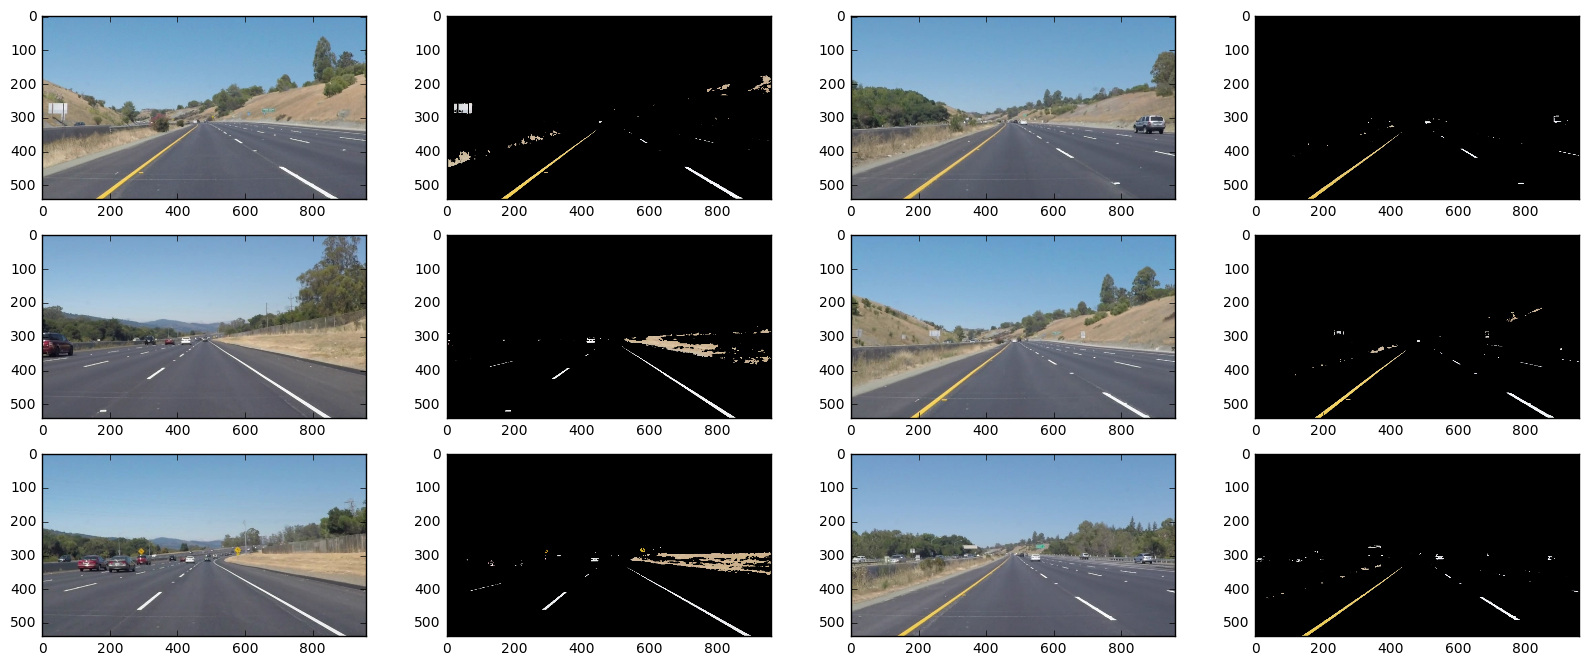

In [5]:
# test Preprocessing images
import os
boundaries = [
    ([196, 145, 10], [255, 245, 180]),
    ([200, 200, 200], [255, 255, 255])
]
dir = 'test_images/'
testImages = os.listdir(dir)
figure = plt.figure(figsize=(20, 8))
counter = 1
for img in testImages:
    
    figure.add_subplot(3,4,counter)
    counter = counter +1
    image = mpimg.imread(dir+img) 
    plt.imshow(image)
    
    result = preProcess(image, boundaries)
    figure.add_subplot(3,4,counter)
    counter = counter +1
    plt.imshow(result)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [6]:
def laneDetection(inputImage, boundaries, preProcessingFlag=True, intelligentFlag = True, extrapolateFlag= True, showMask=False,kernel_size = 5, min_line_len = 20,max_line_gap = 6 , low_threshold = 95,high_threshold =  120,rho = 1,theta = np.pi/180,threshold = 10, color=[255,0,0],thickness=2,alpha=5,beta=10):
    #img = mpimg.imread(inputImage) 
    #img = (mpimg.imread(test)*255).astype('uint8')
    img = inputImage
    if preProcessingFlag==True:
         img = preProcess(img, boundaries)
    gray = grayscale(img) # convert image from RGB to gray
    grayG = gaussian_blur(gray, kernel_size) #Gaussian filter is applied to remove the scharp edges
    cannyImg = canny(grayG, low_threshold, high_threshold) # apply canny edge detection algorithm

    # mask detection
    if not intelligentFlag:
        # add simple mask - handmade
        imshape = cannyImg.shape
        vertices = np.array([[(0,imshape[0]),(imshape[1]/2+3*imshape[0]/70, imshape[0]/3+imshape[0]/4), (imshape[1]/2+imshape[0]/70, imshape[0]/3+imshape[0]/4), (imshape[1],imshape[0])]], dtype=np.int32)
        masked = region_of_interest(cannyImg,vertices)
    else:
        # find the horizon line - adaptive masking
        # better way is finding slope and intersection between two lines
        masked = cannyImg
        
    houghImg, successfulFlag = hough_lines(masked, rho, theta, threshold, min_line_len, max_line_gap,color,thickness,intelligentFlag, extrapolateFlag,showMask,alpha,beta)
    if successfulFlag==True:
        houghRGB = np.dstack((houghImg*(color[0]//255), houghImg*(color[1]//255), houghImg*(color[2]//255))) # *(color[1]/255)
        result = weighted_img(inputImage, houghRGB,  α=1., β=0.8, λ=0.)
        return result
    else:
        return inputImage

/home/vpcom/anaconda3/envs/udacityProject/lib/python3.5/site-packages/ipykernel/__main__.py:33: RuntimeWarning: divide by zero encountered in int_scalars


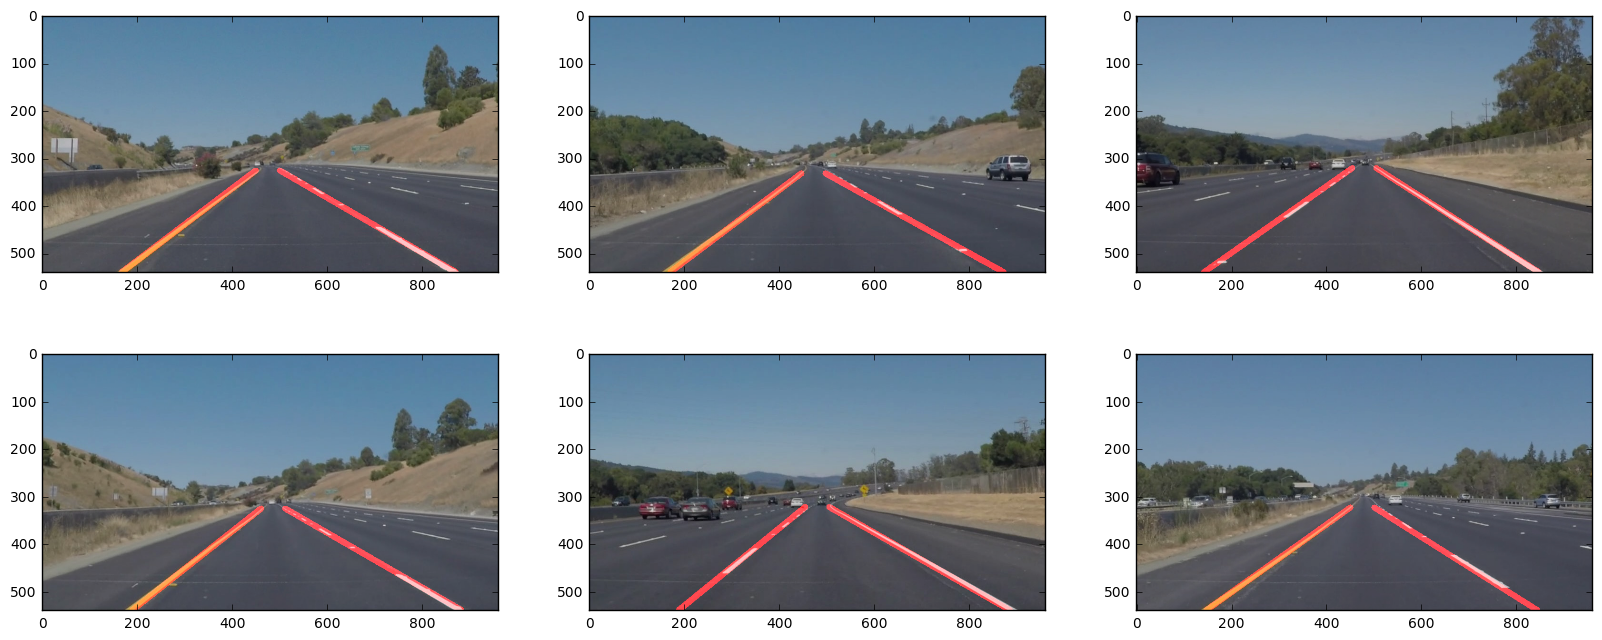

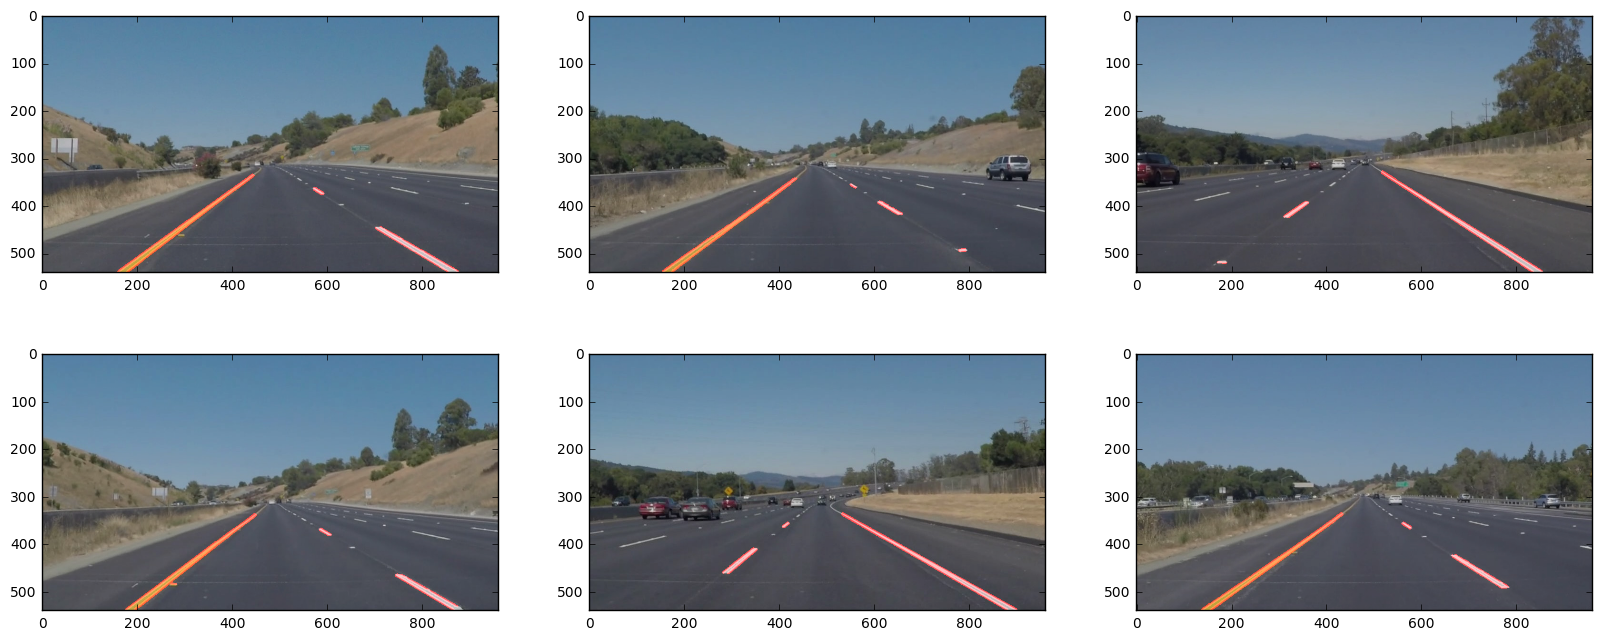

In [7]:
# import libraries
import os

dir = 'test_images/'
saveDir = 'test_images_results/'
testImages = os.listdir(dir)
#print(testImages)
# config
figure = plt.figure(figsize=(20, 8))
kernel_size = 5 # size of kernel for gaussian blur algorithm # 5
low_threshold = 95 # canny edge detection low threshold # 95
high_threshold =  120 # canny edge detection high threshold # 120
rho = 1 # distance resolution in pixels of the Hough grid # 1
theta = np.pi/180 # angular resolution in radians of the Hough grid # np.pi/180
threshold = 10    # minimum number of votes (intersections in Hough grid cell) # 10
min_line_len = 10 # minimum number of pixels making up a line # 20
max_line_gap = 6    # maximum gap in pixels between connectable line segments # 6
thickness = 3
alpha = 25 # my heuristic parameter for my special algorithm intelligentMask Detection to tune x mask position
beta = 16 # my heuristic parameter for my special algorithm intelligentMask Detection to tune y mask position
color = [255,0,0]
boundaries = [
    ([196, 145, 10], [255, 245, 180]),
    ([200, 200, 200], [255, 255, 255])
] # colors we want to keep after pre processing
# Flags
intelligentFlag = True # True
extrapolateFlag = True
saveFlag = False
showMask = False # only works for intelligent mask detection
preProcessingFlag = True

if extrapolateFlag==True:
    intelligentFlag = True
    
    
if saveFlag==True:
    if not os.path.exists(saveDir):
        os.mkdir(saveDir)
# my working pipeline
counter = 1
for img in testImages:
    image = mpimg.imread(dir+img) 
    
    res = laneDetection(image,boundaries, preProcessingFlag,intelligentFlag,extrapolateFlag,showMask,kernel_size,min_line_len,max_line_gap,low_threshold,high_threshold,rho,theta,threshold,color,thickness,alpha,beta)
    if saveFlag==True:
        currentDir = saveDir+'Extrapolate_'+img
        mpimg.imsave(currentDir, res)
        print(currentDir+' successfully saved with Extrapolate_ prefix :D')
    
    
    figure.add_subplot(2,3,counter)
    counter = counter +1
    plt.imshow(res) # show only the latest one 
    
# run again without extrapolate 
# Flags
figure2 = plt.figure(figsize=(20, 8))
intelligentFlag = True # True
extrapolateFlag = False

if extrapolateFlag==True:
    intelligentFlag = True
    
# my working pipeline
counter = 1
for img in testImages:
    image = mpimg.imread(dir+img) 
    res = laneDetection(image,boundaries, preProcessingFlag,intelligentFlag,extrapolateFlag,showMask,kernel_size,min_line_len,max_line_gap,low_threshold,high_threshold,rho,theta,threshold,color,thickness,alpha,beta)
    if saveFlag==True:
        currentDir = saveDir+'Lines_'+img
        mpimg.imsave(currentDir, res)
        print(currentDir+' successfully saved with Lines_ prefix :D')
    
    figure2.add_subplot(2,3,counter)
    counter = counter +1
    plt.imshow(res) # show only the latest one 
 

run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [8]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [9]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    result = laneDetection(image,boundaries, preProcessingFlag,intelligentFlag,extrapolateFlag,showMask,kernel_size,min_line_len,max_line_gap,low_threshold,high_threshold,rho,theta,threshold,color,thickness,alpha,beta)
    return result

Let's try the one with the solid white lane on the right first ...

In [11]:
# config
kernel_size = 5 #size of kernel for gaussian blur algorithm # 5
low_threshold = 45 # canny edge detection low threshold # 95
high_threshold =  120 # canny edge detection high threshold # 120
rho = 1 # distance resolution in pixels of the Hough grid # 1
theta = np.pi/180 # angular resolution in radians of the Hough grid # np.pi/180
threshold = 10    # minimum number of votes (intersections in Hough grid cell) # 10
min_line_len = 10 # minimum number of pixels making up a line # 20
max_line_gap = 6    # maximum gap in pixels between connectable line segments # 6
thickness = 3
alpha = 30 # my heuristic parameter for my special algorithm intelligentMask Detection to tune x mask position
beta = 16 # my heuristic parameter for my special algorithm intelligentMask Detection to tune y mask position
color = [255,0,0]
boundaries = [
    ([196, 145, 10], [255, 245, 180]),
    ([200, 200, 200], [255, 255, 255])
] # colors we want to keep after pre processing
# Flags
intelligentFlag = True # True
extrapolateFlag = True
saveFlag = False
showMask = False # only works for intelligent mask detection
preProcessingFlag = True

if extrapolateFlag==True:
    intelligentFlag = True

white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:12<00:00, 18.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 1min 19s, sys: 2.86 s, total: 1min 22s
Wall time: 13 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [13]:
# config
kernel_size = 5 # size of kernel for gaussian blur algorithm # 5
low_threshold = 40 # canny edge detection low threshold # 95
high_threshold =  120 # canny edge detection high threshold # 120
rho = 1 # distance resolution in pixels of the Hough grid # 1
theta = np.pi/180 # angular resolution in radians of the Hough grid # np.pi/180
threshold = 10    # minimum number of votes (intersections in Hough grid cell) # 10
min_line_len = 10 # minimum number of pixels making up a line # 20
max_line_gap = 6    # maximum gap in pixels between connectable line segments # 6
thickness = 3
alpha = 20 # my heuristic parameter for my special algorithm intelligentMask Detection to tune x mask position
beta = 16 # my heuristic parameter for my special algorithm intelligentMask Detection to tune y mask position
color = [255,0,0]
boundaries = [
    ([196, 145, 10], [255, 245, 180]),
    ([200, 200, 200], [255, 255, 255])
] # colors we want to keep after pre processing
# Flags
intelligentFlag = True # True
extrapolateFlag = True
saveFlag = False
showMask = False # only works for intelligent mask detection
preProcessingFlag = True

if extrapolateFlag==True:
    intelligentFlag = True

yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:39<00:00, 17.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 4min 10s, sys: 8.47 s, total: 4min 19s
Wall time: 40.4 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


## Submission

If you're satisfied with your video outputs it's time to submit!


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [15]:
# config
kernel_size = 5 # size of kernel for gaussian blur algorithm # 5
low_threshold = 40 # canny edge detection low threshold # 95
high_threshold =  120 # canny edge detection high threshold # 120
rho = 1 # distance resolution in pixels of the Hough grid # 1
theta = np.pi/180 # angular resolution in radians of the Hough grid # np.pi/180
threshold = 30    # minimum number of votes (intersections in Hough grid cell) # 10
min_line_len = 10 # minimum number of pixels making up a line # 20
max_line_gap = 6    # maximum gap in pixels between connectable line segments # 6
thickness = 3
alpha = 20 # my heuristic parameter for my special algorithm intelligentMask Detection to tune x mask position
beta = 16 # my heuristic parameter for my special algorithm intelligentMask Detection to tune y mask position
color = [255,0,0]
boundaries = [
    ([196, 145, 10], [255, 245, 180]),
    ([200, 200, 200], [255, 255, 255])
] # colors we want to keep after pre processing
# Flags
intelligentFlag = True # True
extrapolateFlag = True
saveFlag = False
showMask = False # only works for intelligent mask detection
preProcessingFlag = True

if extrapolateFlag==True:
    intelligentFlag = True

challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:26<00:00,  8.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 2min 46s, sys: 5.86 s, total: 2min 52s
Wall time: 27.5 s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))